## Tutorial VI.1

Consider a long-term multi-year investment problem where **CSP (Concentrated Solar Power)** has a learning curve such that

$$LCOE = c_0 \left(\frac{x_t}{x_0}\right)^{-\gamma} + c_1$$

where $c_0$ is cost at start, $c_1$ is material cost and $x_t$ is cumulative
capacity in the investment interval $t$. Thus, $x_0$ is the initial cumulative CSP capacity.

Additionally, there are **nuclear** and **coal** generators for which there is no potential for reducing their LCOE.

We build an optimisation to minimise the cost of supplying a flat demand $d=100$ with the given technologies between 2020 and 2050, where a CO$_2$ budget cap is applied.

> **Hint:** Problem formulation is to be found further along this notebook.

**Task:** Explore different discount rates, learning rates, CO$_2$ budgets. For instance
* No learning for CSP and no CO$_2$ budget would result in a coal-reliant system.
* A CO$_2$ budget and no learning prefers a system built on nuclear.
* A CO$_2$ budget and learning results in a system with CSP.

***
## Imports

In [6]:
from pyomo.environ import ConcreteModel, Var, Objective, NonNegativeReals, Constraint, Suffix, exp
from pyomo.opt import SolverFactory
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pwlf
plt.style.use('bmh')
%matplotlib inline

## Parameters

In [43]:
techs = ["coal","nuclear","CSP"]
colors = ["#707070","#ff9000","#f9d002"]
parameters = pd.DataFrame(columns=techs)
parameters.loc["current annuity"] = [15.*8760,90.*8760,150.*8760] # EUR/MW/a
parameters.loc["potential annuity"] = [15.*8760,90.*8760,35.*8760] # EUR/MW/a
parameters.loc["learning parameter"] = [0.,0.,0.333]
parameters.loc["marginal cost"] = [35.,10.,0.] #EUR/MWhel
parameters.loc["specific emissions"] = [1.,0.,0.] #tcO2/MWhel
parameters.loc["lifetime"] = [40,40,30]  #years
parameters.loc["existing age"] = [20,30,0] #years
parameters.loc["existing capacity"] = [75,25,0] #GW

parameters.loc["current LCOE"] = parameters.loc["current annuity"]/8760 + parameters.loc["marginal cost"]
parameters.loc["potential LCOE"] = parameters.loc["potential annuity"]/8760 + parameters.loc["marginal cost"]

parameters

coal   nuclear          CSP
current annuity     131400.0  788400.0  1314000.000
potential annuity   131400.0  788400.0   306600.000
learning parameter       0.0       0.0        0.333
marginal cost           35.0      10.0        0.000
specific emissions       1.0       0.0        0.000
lifetime                40.0      40.0       30.000
existing age            20.0      30.0        0.000
existing capacity       75.0      25.0        0.000
current LCOE            50.0     100.0      150.000
potential LCOE          50.0     100.0       35.000

(0, 1314000.0)

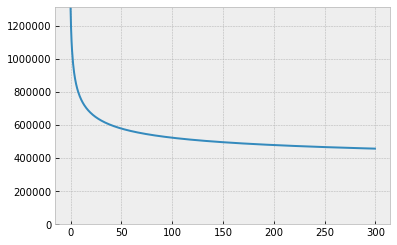

In [44]:
x = np.arange(0,300,0.5)
y = parameters.at["potential annuity","CSP"]+(parameters.at["current annuity","CSP"]-parameters.at["potential annuity","CSP"])*(1+x)**(-parameters.at["learning parameter","CSP"])
fig,ax = plt.subplots()
ax.plot(x,y)

ax.set_ylim([0,y.max()])

(0, 1314000.0)

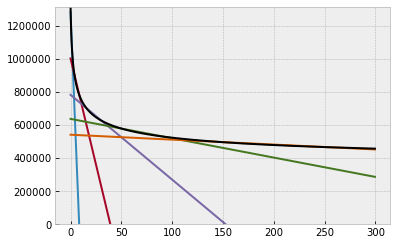

In [45]:
#initialize piecewise linear fit with your x and y data
my_pwlf = pwlf.PiecewiseLinFit(x, y)

n_segments = 5

# fit the data for four line segments
res = my_pwlf.fit(n_segments)

# predict for the determined points
xHat = res
yHat = my_pwlf.predict(res)
#y = ax + b
a = []
b = []
for i in range(len(xHat)-1):
    a.append((yHat[i]-yHat[i+1])/(xHat[i]-xHat[i+1]))
    b.append(yHat[i] - a[i]*xHat[i])
    
fig,ax = plt.subplots()


for i in range(len(a)):
    ax.plot(x,a[i]*x+b[i])
ax.plot(x,y,color="k")  
ax.set_ylim([0,y.max()])

In [46]:
#discount rate
rate = 0.0

#demand in GW
demand = 100.

# carbon budget in average tCO2/MWh_el
co2_budget = 0.2

# considered years
years = list(range(2020,2070))

scenario = "co2-0p2-no_learning"
scenario = "no_co2-no_learning"
scenario = "co2-0p2-learning"


if "no_learning" in scenario:
    parameters.loc["learning parameter"] = 0
if "no_co2" in scenario:
    co2_budget = 2.

## Build Model
> **Note:** We use [`pyomo`](https://pyomo.readthedocs.io/en/stable/) for building optimisation problems in python. This is also what `pypsa` uses under the hood.

In [47]:
model = ConcreteModel("discounted total costs")

Generator capacity available for tech $s$ in year $a$
$$G_{s,a}$$

In [48]:
model.generators = Var(techs, years, within=NonNegativeReals)

Generator dispatch for tech $s$ in year $a$
$$g_{s,a}$$

In [49]:
model.generators_dispatch = Var(techs, years, within=NonNegativeReals)

New capacity built for tech $s$ in year $a$ 
$$Q_{s,a}$$

In [50]:
model.generators_built = Var(techs, years, within=NonNegativeReals)

$$c_{s,a}$$

In [51]:
model.fixed_costs = Var(techs, years, within=NonNegativeReals)

The objective is to minimise the system costs:

$$\min \quad \sum_{s\in S, a\in A} \frac{1}{10^6\cdot (1+r)^{a}} \left( o_{s,a} \cdot g_{s,a} \cdot 8760 + \sum_{b} c_{s,b} Q_{s,b} \mathbb{I}(a \geq b) \mathbb{I}(a < b+L_s) \right) $$

In [52]:
# in billion EUR

# annuities from existing generators
# in billion (MW to GW *1e3, then devide by 1e9)
constant =sum(parameters.at["existing capacity",tech]*parameters.at["current annuity",tech]/1e6/(1+rate)**(year-years[0]) for tech in techs for year in years if year < years[0] + parameters.at["lifetime",tech] - parameters.at["existing age",tech])
print(constant)

model.objective = Objective(expr=constant +
                                 sum(model.generators_built[tech,year]*model.fixed_costs[tech,year]/1e6*sum(1/(1+rate)**(yearb-years[0]) for yearb in years if ((yearb>= year) and (yearb < year + parameters.at["lifetime",tech])))
                                     for year in years
                                     for tech in techs) + 
                                 sum(model.generators_dispatch[tech,year]*parameters.at["marginal cost",tech]*8760/1e6/(1+rate)**(year-years[0])
                                     for year in years
                                     for tech in techs))

394.1999999999998


Add a constraint such that demand is met by generator dispatch:

$$\forall a\in A: \quad d = \sum_{s \in S} g_{s,a}$$

In [53]:
def balance_constraint(model, year):
    return demand == sum(model.generators_dispatch[tech,year] for tech in techs)
model.balance_constraint = Constraint(years, rule=balance_constraint)

$$ g_{s,a} \leq G_{s,a} $$

In [54]:
def generator_constraint(model, tech, year):
    return model.generators_dispatch[tech,year] <= model.generators[tech,year]
model.generator_constraint = Constraint(techs, years, rule=generator_constraint)

Add a constraint on carbon dioxide emissions:

$$\sum_{s\in S, a\in A} G_{s,a} \cdot e_{t} \leq \hat{e} \cdot |A| \cdot d$$

In [55]:
def co2_constraint(model):
    return co2_budget*len(years)*demand >= sum(model.generators_dispatch[tech,year]*parameters.at["specific emissions",tech] for tech in techs for year in years)
model.co2_constraint = Constraint(rule=co2_constraint)

In [56]:
def fixed_cost_constraint(model,tech,year):
    if parameters.at["learning parameter",tech] == 0:
        return model.fixed_costs[tech,year] == parameters.at["current annuity",tech]
    else:
        return model.fixed_costs[tech,year] == parameters.at["potential annuity",tech] + (parameters.at["current annuity",tech]-parameters.at["potential annuity",tech])*(1+sum(model.generators[tech,yeart] for yeart in years if yeart < year))**(-parameters.at["learning parameter",tech])
model.fixed_cost_constraint = Constraint(techs, years, rule=fixed_cost_constraint)

In [57]:
def build_years(model,tech,year):
    if year < years[0] + parameters.at["lifetime",tech] - parameters.at["existing age",tech]:
        constant = parameters.at["existing capacity",tech]
    else:
        constant = 0.
    
    return model.generators[tech,year] == constant + sum(model.generators_built[tech,yearb] for yearb in years if ((year>= yearb) and (year < yearb + parameters.at["lifetime",tech])))
model.build_years = Constraint(techs, years, rule=build_years)

> **Hint:** You can print the model formulation with `model.pprint()`

## Solve Model

In [58]:
opt = SolverFactory("ipopt")

In [59]:
results = opt.solve(model,suffixes=["dual"],keepfiles=False)

## Results

Optimised cost (in billion euros NPV):

In [60]:
print(model.objective())

2559.453538442794


The unoptimized cost (where everything is supplied by coal) is:

In [61]:
print(8760*demand*parameters.at["current LCOE","coal"]*len(years)/1e6)

2190.0


In [62]:
dispatch = pd.DataFrame(0.,index=years,columns=techs)
for year in years:
    for tech in techs:
        dispatch.at[year,tech] = model.generators_dispatch[tech,year].value

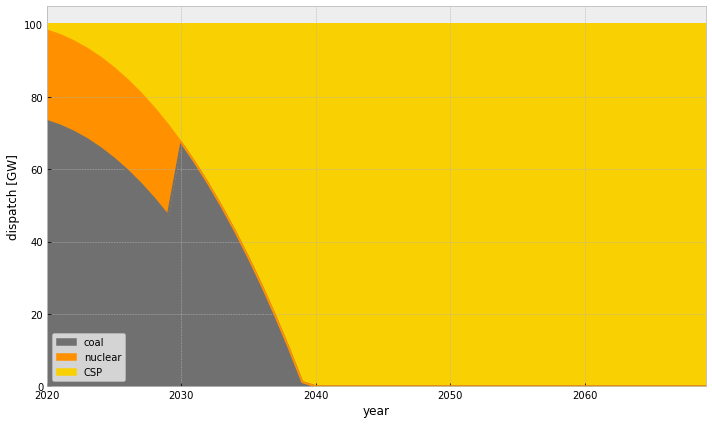

In [63]:
fig, ax = plt.subplots()

fig.set_size_inches((10,6))

dispatch.plot(kind="area",stacked=True,color=colors,ax=ax)
ax.set_xlabel("year")
ax.set_ylabel("dispatch [GW]")

fig.tight_layout()

fig.savefig("{}-dispatch.pdf".format(scenario),transparent=True)

Plotting the development of the technology mix of the optimal solution over time:

In [64]:
capacities = pd.DataFrame(0.,index=years,columns=techs)
for year in years:
    for tech in techs:
        capacities.at[year,tech] = model.generators[tech,year].value

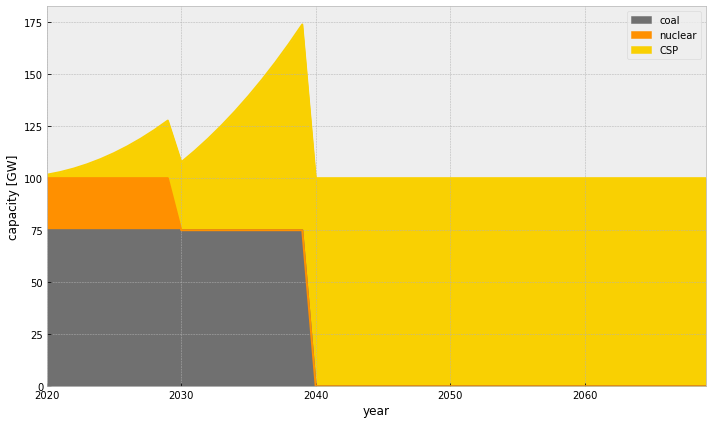

In [65]:
fig, ax = plt.subplots()

fig.set_size_inches((10,6))

capacities.plot(kind="area",stacked=True,color=colors,ax=ax)
ax.set_xlabel("year")
ax.set_ylabel("capacity [GW]")

fig.tight_layout()

fig.savefig("{}-capacity.pdf".format(scenario),transparent=True)

In [66]:
build_years = pd.DataFrame(0.,index=years,columns=techs)
for year in years:
    for tech in techs:
        build_years.at[year,tech] = model.generators_built[tech,year].value

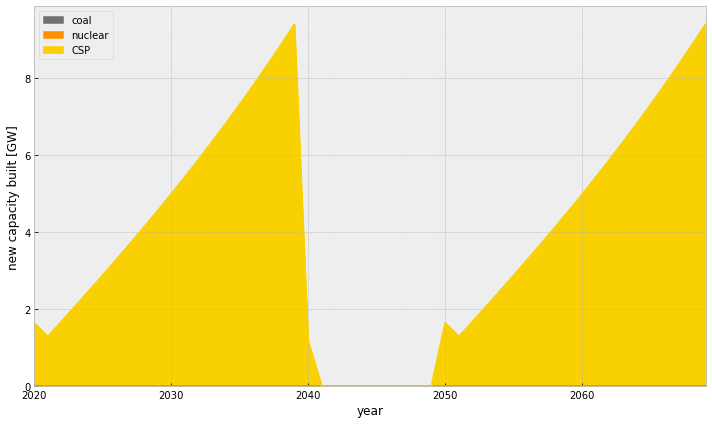

In [67]:
fig, ax = plt.subplots()

fig.set_size_inches((10,6))

build_years.plot(kind="area",stacked=True,color=colors,ax=ax)
ax.set_xlabel("year")
ax.set_ylabel("new capacity built [GW]")

fig.tight_layout()

fig.savefig("{}-new_capacity.pdf".format(scenario),transparent=True)

Plotting the development of the costs of the technology over time:

In [68]:
costs = pd.DataFrame(0.,index=years,columns=techs)
for year in years:
    for tech in techs:
        costs.at[year,tech] = model.fixed_costs[tech,year].value/8760. + parameters.at["marginal cost",tech]

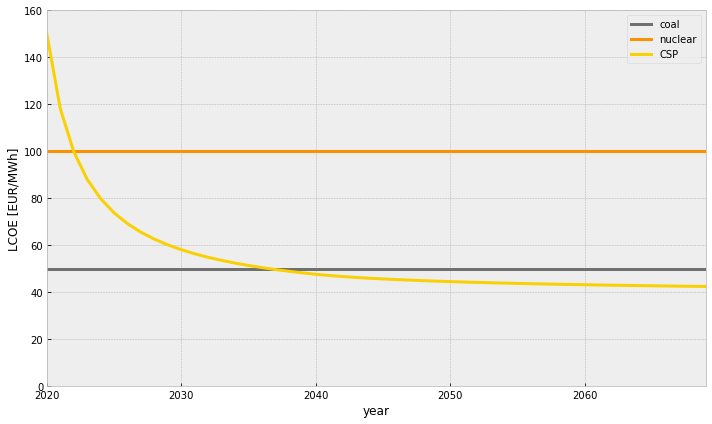

In [69]:
fig, ax = plt.subplots()

fig.set_size_inches((10,6))

costs.plot(color=colors,ax=ax,linewidth=3)
ax.set_xlabel("year")
ax.set_ylabel("LCOE [EUR/MWh]")
ax.set_ylim([0,160])


fig.tight_layout()

fig.savefig("{}-lcoe.pdf".format(scenario),transparent=True)